# Model Training and Evaluation

## 1. Training

### 1.1 Define the Model and Dataset

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

# ---- Model Definition ----
class ResidualBlock(nn.Module):
    def __init__(self, dim, hidden_dim, dropout, act_fn):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            act_fn,
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            # nn.LayerNorm(dim),
            # act_fn,
            # nn.Dropout(dropout)
        )
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        return self.norm(x + self.net(x))
        # return x + self.net(x)

class NonLinearAligner(nn.Module):
    def __init__(self, dropout=0.1, act='gelu'):
        super().__init__()
        act_fn = {
            "gelu": nn.GELU(),
            "silu": nn.SiLU(),
            "leaky_relu": nn.LeakyReLU(0.01)
        }[act]
        self.norm = nn.LayerNorm(512)
        
        self.proj = nn.Sequential(
            # nn.Linear(512, 512),
            # act_fn,
            # nn.Dropout(dropout),
            # ResidualBlock(512, 1024, dropout, act_fn),
            # nn.LayerNorm(512)

            nn.Linear(512, 1024),
            nn.LayerNorm(1024),
            act_fn,
            nn.Dropout(dropout),
            nn.Linear(1024, 512),
            nn.LayerNorm(512),
            act_fn,
            nn.Dropout(dropout),
            ResidualBlock(512, 1024, dropout, act_fn),
            # nn.LayerNorm(512)

            
            # ResidualBlock(512, 1024, dropout, act_fn),
            # ResidualBlock(512, 1024)
            # nn.LayerNorm(512)
        )

    def forward(self, x):
        x = self.proj(x)
        # x = nn.GELU()(x + self.proj(x))
        return F.normalize(x, p=2, dim=-1)

In [12]:
import pickle


# with open("/kaggle/input/dense-caption-0-20/dense_caption_embeds13-20", 'rb') as f:
#     data1 = pickle.load(f)  # List of (img_emb, text_emb)

# with open("/kaggle/input/dense-caption-0-20/dense_caption_embeds14", 'rb') as f:
#     data2 = pickle.load(f)  # List of (img_emb, text_emb)

with open("/kaggle/input/embedded-data-1/cc3m_embeds", 'rb') as f:
    data3 = pickle.load(f)  # List of (img_emb, text_emb)

with open("/kaggle/input/densely-captioned-images-dci-clip-embeddings/dense_caption_embeds", 'rb') as f:
    data4 = pickle.load(f)  # List of (img_emb, text_emb)

# data3.extend(data2)
# data3.extend(data1)
data3.extend(data4)

with open("train_data.pkl", "wb") as fp:   #Pickling
    pickle.dump(data3, fp)


In [14]:
import pickle
import torch
from torch.utils.data import Dataset, DataLoader

# ---- Custom Dataset ----
class EmbeddingPairDataset(Dataset):
    def __init__(self, pickle_path):
        with open(pickle_path, 'rb') as f:
            self.data = pickle.load(f)  # List of (img_emb, text_emb)
        
        self.x = torch.stack([torch.tensor(pair[0], dtype=torch.float32) for pair in self.data])
        self.y = torch.stack([torch.tensor(pair[1], dtype=torch.float32) for pair in self.data])

        # Optionally verify normalization
        if not torch.allclose(self.x.norm(dim=1), torch.ones(len(self.x)), atol=1e-2):
            print("Warning: image embeddings not normalized.")
        if not torch.allclose(self.y.norm(dim=1), torch.ones(len(self.y)), atol=1e-2):
            print("Warning: text embeddings not normalized.")

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


### 1.2. Define and Conduct Training

In [15]:
# ---- Training Function ----
def train_model(model, dataloader, val_loader, optimizer, device, epochs=10, lambda_cos=0.1, eval_every=0.3):
    model.to(device)
    model.train()
    train_loss = []
    val_loss = []
    last_val_loss = 0
    static_val_loss_counter = 0
    
    for epoch in range(epochs):
        total_loss = 0
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}")
        if static_val_loss_counter >= 4:
            print("Early stopping!")
            break
        for x, y in pbar:
            x, y = x.to(device), y.to(device)

            pred = model(x)
            # This is the loss function
            # mse = F.mse_loss(pred, y)
            # loss = mse
            # For now let's not use cosine loss
            # Uncomment the following lines if you want to include cosine similarity loss
            cosine = 1 - F.cosine_similarity(pred, y, dim=-1).mean()  # 1 - cos for minimization
            loss = cosine
            # loss = mse + lambda_cos * cosine


            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            pbar.set_postfix(loss=loss.item())

        train_loss.append((epoch, total_loss / len(dataloader)))
        print(f"Epoch {epoch+1}: Avg Loss = {total_loss / len(dataloader):.4f}")

        if val_loader is not None and epoch % eval_every == 0:
            model.eval()
            total_val_loss = 0
            with torch.no_grad():
                for x_val, y_val in val_loader:
                    x_val, y_val = x_val.to(device), y_val.to(device)
                    pred_val = model(x_val)
                    # loss_val = F.mse_loss(pred_val, y_val)

                    cosine_val = 1 - F.cosine_similarity(pred_val, y_val, dim=-1).mean()
                    loss_val = cosine_val
                    
                    # if use_cosine:
                    #     cosine_val = 1 - F.cosine_similarity(pred_val, y_val, dim=-1).mean()
                    #     loss_val = loss_val + lambda_cos * cosine_val
                    
                    total_val_loss += loss_val.item()
            avg_val = total_val_loss / len(val_loader)
            val_loss.append((epoch, avg_val))
            if abs(last_val_loss - avg_val) <= 0.005:
                static_val_loss_counter += 1
            elif avg_val > last_val_loss:
                static_val_loss_counter += 2
            else:
                static_val_loss_counter = 0
            last_val_loss = avg_val
            print(f" | Val Loss = {avg_val:.4f}")
        else:
            print()
    
    return model, train_loss, val_loss

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [19]:
from torch.utils.data import random_split


# def setup_and_train_from_pickle(pickle_path, batch_size=128, lr=1e-4, epochs=10, act='gelu'):
#     dataset = EmbeddingPairDataset(pickle_path)
#     dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

#     model = NonLinearAligner(act=act)
#     optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

#     train_model(model, dataloader, optimizer, device, epochs=epochs)

#     return model


def prepare_dataloaders(pickle_path, batch_size=128, val_split=0.1, seed=13):
    dataset = EmbeddingPairDataset(pickle_path)
    N = len(dataset)
    val_size = int(N * val_split)
    train_size = N - val_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size],
                                     generator=torch.Generator().manual_seed(seed))

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader


def setup_and_train_with_eval(pickle_path, batch_size=128, lr=1e-4, 
                              epochs=10, act='gelu', val_split=0.1,
                              eval_every=3):
    train_loader, val_loader = prepare_dataloaders(pickle_path, batch_size, val_split)
    model = NonLinearAligner(act=act)
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    model, train_loss, val_loss = train_model(model, train_loader, val_loader, optimizer, device, 
                epochs=epochs, eval_every=eval_every)
    return model, train_loss, val_loss

In [37]:
# filename = "/kaggle/input/embedded-data-1/cc3m_embeds"
filename = "/kaggle/working/train_data.pkl"

model, train_loss, val_loss = setup_and_train_with_eval(filename, batch_size=128, lr=1e-4, 
                                  epochs=30, act='gelu', val_split=0.05,
                                  eval_every=3)
print("Training complete.")


/tmp/ipykernel_35/17808087.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.stack([torch.tensor(pair[0], dtype=torch.float32) for pair in self.data])
/tmp/ipykernel_35/17808087.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.stack([torch.tensor(pair[1], dtype=torch.float32) for pair in self.data])
Epoch 1: 100%|██████████| 133/133 [00:00<00:00, 170.69it/s, loss=0.394]


Epoch 1: Avg Loss = 0.4740
 | Val Loss = 0.3696


Epoch 2: 100%|██████████| 133/133 [00:00<00:00, 178.69it/s, loss=0.316]


Epoch 2: Avg Loss = 0.3337



Epoch 3: 100%|██████████| 133/133 [00:00<00:00, 181.49it/s, loss=0.292]


Epoch 3: Avg Loss = 0.2918



Epoch 4: 100%|██████████| 133/133 [00:00<00:00, 177.97it/s, loss=0.279]


Epoch 4: Avg Loss = 0.2719
 | Val Loss = 0.2698


Epoch 5: 100%|██████████| 133/133 [00:00<00:00, 175.10it/s, loss=0.26] 


Epoch 5: Avg Loss = 0.2602



Epoch 6: 100%|██████████| 133/133 [00:00<00:00, 178.09it/s, loss=0.232]


Epoch 6: Avg Loss = 0.2522



Epoch 7: 100%|██████████| 133/133 [00:00<00:00, 179.94it/s, loss=0.246]


Epoch 7: Avg Loss = 0.2460
 | Val Loss = 0.2523


Epoch 8: 100%|██████████| 133/133 [00:00<00:00, 178.16it/s, loss=0.254]


Epoch 8: Avg Loss = 0.2415



Epoch 9: 100%|██████████| 133/133 [00:00<00:00, 175.50it/s, loss=0.268]


Epoch 9: Avg Loss = 0.2374



Epoch 10: 100%|██████████| 133/133 [00:00<00:00, 179.32it/s, loss=0.241]


Epoch 10: Avg Loss = 0.2335
 | Val Loss = 0.2457


Epoch 11: 100%|██████████| 133/133 [00:00<00:00, 179.34it/s, loss=0.239]


Epoch 11: Avg Loss = 0.2302



Epoch 12: 100%|██████████| 133/133 [00:00<00:00, 180.30it/s, loss=0.244]


Epoch 12: Avg Loss = 0.2272



Epoch 13: 100%|██████████| 133/133 [00:00<00:00, 176.30it/s, loss=0.215]


Epoch 13: Avg Loss = 0.2239
 | Val Loss = 0.2423


Epoch 14: 100%|██████████| 133/133 [00:00<00:00, 179.20it/s, loss=0.263]


Epoch 14: Avg Loss = 0.2213



Epoch 15: 100%|██████████| 133/133 [00:00<00:00, 179.71it/s, loss=0.217]


Epoch 15: Avg Loss = 0.2182



Epoch 16: 100%|██████████| 133/133 [00:00<00:00, 181.20it/s, loss=0.229]


Epoch 16: Avg Loss = 0.2155
 | Val Loss = 0.2430


Epoch 17: 100%|██████████| 133/133 [00:00<00:00, 178.48it/s, loss=0.233]


Epoch 17: Avg Loss = 0.2125



Epoch 18: 100%|██████████| 133/133 [00:00<00:00, 175.68it/s, loss=0.229]


Epoch 18: Avg Loss = 0.2098



Epoch 19: 100%|██████████| 133/133 [00:00<00:00, 180.66it/s, loss=0.191]


Epoch 19: Avg Loss = 0.2069
 | Val Loss = 0.2433


Epoch 20: 100%|██████████| 133/133 [00:00<00:00, 177.74it/s, loss=0.192]


Epoch 20: Avg Loss = 0.2041



Epoch 21: 100%|██████████| 133/133 [00:00<00:00, 177.11it/s, loss=0.193]


Epoch 21: Avg Loss = 0.2013



Epoch 22: 100%|██████████| 133/133 [00:00<00:00, 157.56it/s, loss=0.189]


Epoch 22: Avg Loss = 0.1989
 | Val Loss = 0.2455


Epoch 23:   0%|          | 0/133 [00:00<?, ?it/s]


Early stopping!
Training complete.


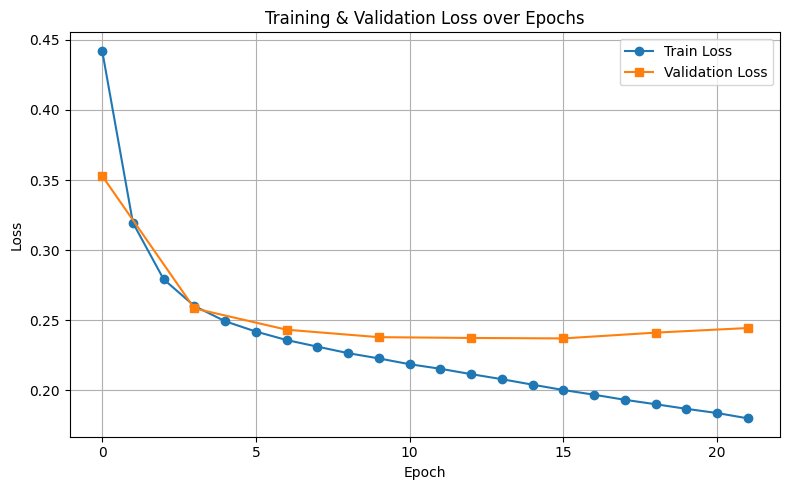

In [21]:
import matplotlib.pyplot as plt

train_epochs = [e for e, _ in train_loss]
train_vals   = [l for _, l in train_loss]

val_epochs   = [e for e, _ in val_loss]
val_vals     = [l for _, l in val_loss]

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

# Plot training loss (every epoch)
plt.plot(train_epochs, train_vals, '-o', label='Train Loss')

# Only plot validation loss at the evaluated steps
plt.plot(val_epochs, val_vals, '-s', label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
torch.save(model.state_dict(), "/kaggle/working/model_basic_cosine_full_data")

## 2. Evaluation

### 2.1. Evaluate the Modality Gap

In [38]:
eval_file_name = "/kaggle/input/embedded-data-1/coco_embeds"

with open(eval_file_name, 'rb') as f:
    data = pickle.load(f)

x = torch.stack([torch.tensor(pair[0], dtype=torch.float32) for pair in data]).to(device)
y = torch.stack([torch.tensor(pair[1], dtype=torch.float32) for pair in data]).to(device)

# Apply model to image embeddings
model.eval()
with torch.no_grad():
    pred_y = model(x)

/tmp/ipykernel_35/1157884353.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.stack([torch.tensor(pair[0], dtype=torch.float32) for pair in data]).to(device)
/tmp/ipykernel_35/1157884353.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.stack([torch.tensor(pair[1], dtype=torch.float32) for pair in data]).to(device)


In [24]:
def l2m(x, y):
    mean_img = x.mean(dim=0)
    mean_text = y.mean(dim=0)
    return torch.norm(mean_img - mean_text).item()

In [25]:
def alignment(x, y):
    x = F.normalize(x, p=2, dim=-1)
    y = F.normalize(y, p=2, dim=-1)
    cos_sim = F.cosine_similarity(x, y, dim=-1)
    return cos_sim.mean().item()

In [26]:
# Helper function for RMG calculating intra-model distance for one modality
def sum_intra_modal_dist(vectors, N):
    dists = torch.cdist(vectors, vectors, p=2)
    mask = ~torch.eye(N, dtype=torch.bool, device=dists.device)
    return dists[mask].sum().item()

def rmg(x, y):
    N = x.size(0)

    # Inter-modal distance (between matching pairs)
    inter_dists = torch.norm(x - y, dim=1)
    inter_modal_mean = inter_dists.mean().item()

    intra_model_sum_x = sum_intra_modal_dist(x, N)
    intra_model_sum_y = sum_intra_modal_dist(y, N)

    rmg = inter_modal_mean / (inter_modal_mean + (intra_model_sum_x + intra_model_sum_y) / (2 * N * (N - 1)))
    return rmg

In [27]:
l2m_before = l2m(x, y)
l2m_after = l2m(pred_y, y)

print(f"L2M (Before): {l2m_before:.4f}")
print(f"L2M (After):  {l2m_after:.4f}")

alignment_before = alignment(x, y)
alignment_after = alignment(pred_y, y)

print(f"Alignment (Before): {alignment_before:.4f}")
print(f"Alignment (After):  {alignment_after:.4f}")

rmg_before = rmg(x, y)
rmg_after = rmg(pred_y, y)

print(f"RMG (Before): {rmg_before:.4f}")
print(f"RMG (After):  {rmg_after:.4f}")

L2M (Before): 0.7508
L2M (After):  0.2192
Alignment (Before): 0.3455
Alignment (After):  0.7461
RMG (Before): 0.5138
RMG (After):  0.4041


In [141]:
l2m_before = l2m(x, y)
l2m_after = l2m(pred_y, y)

print(f"L2M (Before): {l2m_before:.4f}")
print(f"L2M (After):  {l2m_after:.4f}")

alignment_before = alignment(x, y)
alignment_after = alignment(pred_y, y)

print(f"Alignment (Before): {alignment_before:.4f}")
print(f"Alignment (After):  {alignment_after:.4f}")

rmg_before = rmg(x, y)
rmg_after = rmg(pred_y, y)

print(f"RMG (Before): {rmg_before:.4f}")
print(f"RMG (After):  {rmg_after:.4f}")

L2M (Before): 0.7508
L2M (After):  0.2303
Alignment (Before): 0.3455
Alignment (After):  0.7497
RMG (Before): 0.5138
RMG (After):  0.4058


In [98]:
import sklearn.metrics.pairwise as pairwise

ind = 108
print(F.mse_loss(pred_y[ind].reshape(1, -1), y[ind].reshape(1, -1)))
print(pairwise.cosine_similarity(pred_y[ind].cpu().reshape(1, -1), y[ind].cpu().reshape(1, -1)))
print(F.cosine_similarity(pred_y[ind], y[ind], dim=-1))

tensor(0.0011, device='cuda:0')
[[0.71449697]]
tensor(0.7145, device='cuda:0')


### 2.2 Evaluate Zero-Shot Classification Performance

In [1]:
# !git clone --depth 1 https://github.com/openai/CLIP.git

Cloning into 'CLIP'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 30 (delta 0), reused 10 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (30/30), 4.12 MiB | 18.17 MiB/s, done.


In [1]:
pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-03u4plh0
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-03u4plh0
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [8]:
import os
import clip
import torch
from torchvision.datasets import CIFAR100

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model_clip, preprocess = clip.load('ViT-B/32', device)


# Download the dataset
cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)


# Prepare the inputs
# for i in range(len(cifar100)):
image, class_id = cifar100[3635]
image_input = preprocess(image).unsqueeze(0).to(device)
text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)


# Calculate features, change them to float32
with torch.no_grad():
    image_features = model_clip.encode_image(image_input)
    text_features = model_clip.encode_text(text_inputs)

# Pick the top 5 most similar labels for the image
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
values, indices = similarity[0].topk(5)

# Print the result
print("\nTop predictions:\n")
for value, index in zip(values, indices):
    print(f"{cifar100.classes[index]:>16s}: {100 * value.item():.2f}%")


Top predictions:

        oak_tree: 39.48%
     willow_tree: 26.29%
      maple_tree: 15.95%
       pine_tree: 14.31%
       palm_tree: 1.23%


In [30]:
int(class_id  in indices)

0

In [9]:
indices, class_id

(tensor([52, 96, 47, 59, 56], device='cuda:0'), 47)

In [29]:
len(cifar100)

10000

In [ ]:
import os
import clip
import torch
from torchvision.datasets import CIFAR100

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model_clip, preprocess = clip.load('ViT-B/32', device)
top5_acc = []
top1_acc = []


# Download the dataset
cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)

# Prepare the inputs
for i in range(len(cifar100)):
    print(i)
    image, class_id = cifar100[i]
    image_input = preprocess(image).unsqueeze(0).to(device)
    text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)
    
    
    # Calculate features, change them to float32
    with torch.no_grad():
        image_features = model_clip.encode_image(image_input).float()
        text_features = model_clip.encode_text(text_inputs).float()
    
    # Transform image vector
    model.eval()
    with torch.no_grad():
        new_image_features = model(image_features)
    
    # Pick the top 5 most similar labels for the image
    new_image_features /= new_image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = (100.0 * new_image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(5)
    top5_acc.append(int(class_id  in indices))
    values, indices = similarity[0].topk(1)
    top1_acc.append(int(class_id  in indices))
    
    

# Print the result
print("\nAccurarcy:\n")
top5 = sum(top5_acc) / len(cifar100)
top1 = sum(top1_acc) / len(cifar100)

print(f"Top1: {top1}\nTop5: {top5}")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [33]:
len(top5_acc)

10000

In [34]:
len(top1_acc)

10000

In [35]:
print(f"Top1: {top1}\nTop5: {top5}")

Top1: 0.2083
Top5: 0.4837


In [143]:
indices, class_id

(tensor([63, 74, 57, 93, 77], device='cuda:0'), 78)

### Test cross-modal semantics